In [1]:
from datetime import datetime
import joblib
import pandas as pd
from matplotlib import pyplot as plt
import os
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBClassifier

# Exploratory Data Analysis

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
df = pd.read_csv("./dataset/e2e_lending_club_10k_partitioned.csv")

In [3]:
from datarobot.models.dataset import Dataset

# Retrieve a dataset from AI Catalog using its ID
dataset_id = "66059ec49b2d6a16e53456f9"
dataset = Dataset.get(dataset_id)

# Load the dataset into an in-memory pandas dataframe
df = dataset.get_as_dataframe()


In [5]:
df.head()

,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,policy_code,loan_status,Partition
0,1000,1000,36 months,0.1189,33.17,B,B4,fairbanks northstar borough school district,10+ years,MORTGAGE,87000.0,not verified,False,https://www.lendingclub.com/browse/loanDetail....,I recently combined a planned work trip with a...,other,Parent Attend Navy Induction,997xx,AK,5.57,1.0,1986-03-01,0.0,13.0,NaN,5.0,0.0,5742,55.2,18.0,False,1,0,T
1,3500,3500,36 months,0.1189,116.08,B,B4,"Orphic Workshop, LLC",2 years,RENT,30000.0,not verified,False,https://www.lendingclub.com/browse/loanDetail....,"I'm working on paying of my cards, one by one....",credit_card,Refinancing credit card debt,871xx,NM,11.68,0.0,1990-05-01,0.0,71.0,NaN,5.0,0.0,4621,45.8,20.0,False,1,0,T
2,3000,3000,36 months,0.1189,99.50,B,B4,Jon Felts LLC,2 years,RENT,30000.0,not verified,False,https://www.lendingclub.com/browse/loanDetail....,I am a certified golf teaching professional wi...,small_business,Golf Academy,957xx,CA,18.28,0.0,1989-12-01,0.0,40.0,NaN,9.0,0.0,14577,34.7,13.0,False,1,0,T
3,12000,12000,36 months,0.1189,397.97,B,B4,Albany Medical Center,3 years,RENT,40000.0,not verified,False,https://www.lendingclub.com/browse/loanDetail....,Using to pay down credit cards,debt_consolidation,Personal,121xx,NY,14.88,0.0,1992-03-01,0.0,NaN,NaN,3.0,0.0,15280,56.2,14.0,False,1,0,T
4,4000,4000,36 months,0.1189,132.66,B,B4,NYC DOE,2 years,RENT,54000.0,not verified,False,https://www.lendingclub.com/browse/loanDetail....,Seeking an unsecured personal loan. Will be p...,moving,Unsecured Personal Loan,112xx,NY,12.91,1.0,1997-10-01,1.0,8.0,NaN,8.0,0.0,24671,66.0,35.0,False,1,0,T


# Feature Transformation

In [6]:
numeric_transform = SimpleImputer(strategy='constant', fill_value=0)
categoric_tranform = Pipeline(
    steps=[
        ('null_imputation', SimpleImputer(strategy='constant', fill_value='UNKNOWN')),
        ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ]
)

In [7]:
# Col transfomer automatically handles right cols via datatypes
col_transformer = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transform, make_column_selector(dtype_include=[float,int])),
        ('categoric', categoric_tranform, make_column_selector(dtype_include=object))
    ]
)

# Partitioning

In [8]:
training_data = df[df['Partition'] == "T"].drop(labels=['Partition'], axis=1)

In [9]:
training_data.shape

(6400, 33)

In [10]:
validation_data = df[df['Partition'] == "V"].drop(labels=['Partition'], axis=1)

In [11]:
validation_data.shape

(1600, 33)

In [12]:
X_train = training_data.drop(labels='loan_status', axis=1)
y_train = training_data['loan_status']
X_val = validation_data.drop(labels='loan_status', axis=1)
y_val = validation_data['loan_status']

# Set up Managed MLflow on Azure for Experiment Tracking

In [13]:
subscription_id = os.getenv("SUBSCRIPTION_ID")
resource_group = "zhilei.ma-rg"
workspace = "zhileima"

In [14]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

In [15]:
credentials = DefaultAzureCredential()

In [16]:
ml_client = MLClient(
    subscription_id=subscription_id,
    resource_group_name=resource_group,
    credential=credentials,
)

In [17]:
ws = ml_client.workspaces.get(name=workspace)

In [18]:
ws.mlflow_tracking_uri

'azureml://eastus2.api.azureml.ms/mlflow/v1.0/subscriptions/72697d21-ec57-47c8-8998-1924b0ce0784/resourceGroups/zhilei.ma-rg/providers/Microsoft.MachineLearningServices/workspaces/zhileima'

In [19]:
import mlflow

mlflow.set_tracking_uri = ws.mlflow_tracking_uri
mlflow.set_experiment(experiment_name="loan_risk_assessment-2024")

<Experiment: artifact_location='file:///home/notebooks/storage/mlruns/292146430366384955', creation_time=1713802229060, experiment_id='292146430366384955', last_update_time=1713802229060, lifecycle_stage='active', name='loan_risk_assessment-2024', tags={}>

In [20]:
mlflow.xgboost.autolog()

In [21]:
my_run_id = datetime.today().strftime('%Y-%m-%d_%H:%M:%S')
my_run_name="demo" + " " + my_run_id
run = mlflow.start_run(run_name=my_run_name)

In [22]:
mlflow.set_tag("Use Case Owner", "John Doe")
mlflow.set_tag("Data Scientist", "Zhilei Ma")

# Model Training & Evalution

In [23]:
xgb_model = XGBClassifier(
    learning_rate=.1,
    n_estimators=100,
    objective="binary:logistic",
    eval_metric=["logloss"],
    early_stopping_rounds=10,
    verbose=True
)

In [24]:
# Creates the model pipeline object:
model = Pipeline(
    steps=[
        ('col_transformer', col_transformer),
        ('model', xgb_model)
    ]
)

In [25]:
model[:-1].fit(X_train)

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7eff99eae640>),
                                                 ('categoric',
                                                  Pipeline(steps=[('null_imputation',
                                                                   SimpleImputer(fill_value='UNKNOWN',
                                                                                 strategy='constant')),
                                                                  ('ordinal_encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7eff99eae4f0>)]))])

In [26]:
X_val = model[:-1].transform(X_val)

In [27]:
model.fit(
    X_train, 
    y_train, 
    model__eval_set=[(X_val, y_val)]
)

2024/04/22 22:06:04 WARNING mlflow.xgboost: Unable to log dataset information to MLflow Tracking.XGBoost version must be >= 1.7.0
2024/04/22 22:06:04 WARNING mlflow.xgboost: Unable to log dataset information to MLflow Tracking.XGBoost version must be >= 1.7.0
[22:06:04] WARNING: ../src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-logloss:0.65527
[1]	validation_0-logloss:0.60978
[2]	validation_0-logloss:0.58353
[3]	validation_0-logloss:0.55376
[4]	validation_0-logloss:0.52682
[5]	validation_0-logloss:0.50622
[6]	validation_0-logloss:0.48755
[7]	validation_0-logloss:0.47473
[8]	validation_0-logloss:0.46047
[9]	validation_0-logloss:0.44914
[10]	validation_0-logloss:0.43810
[11]	validation_0-

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7eff99eae640>),
                                                 ('categoric',
                                                  Pipeline(steps=[('null_imputation',
                                                                   SimpleImputer(fill_value='UNKNOWN',
                                                                                 strategy='constant')),
                                                                  ('ordinal_encoder',
                                                                   OrdinalEncoder(han...
                               eval_metric=['logloss'], gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='', learning_rate=0.1,
                               max_bin=256, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1, ...))])

In [28]:
eval_results = model.named_steps['model'].evals_result()

# Create and Save The Learning Curve

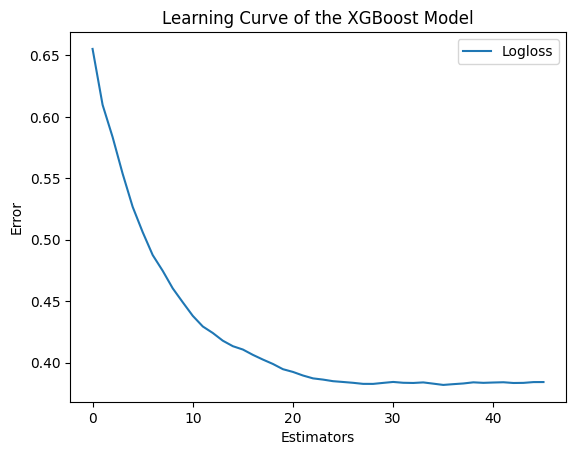

In [29]:
plt.plot(eval_results['validation_0']['logloss'], label='logloss')
plt.xlabel('Estimators')
plt.ylabel('Error')
plt.title('Learning Curve of the XGBoost Model')
plt.legend(['Logloss'])


# save the figure
plt.savefig('./artifact/learning_curve.png', dpi=300, bbox_inches='tight')


plt.show()

In [30]:
# Log the plotted learning curve in MLflow 
mlflow.log_artifact("./artifact/learning_curve.png")

# Serialization

In [31]:
# Serialize and save the trained model
joblib.dump(model, "./deploy/model.pkl")

['./deploy/model.pkl']

# Test & Validate Locally

In [32]:
!drum score -cd ./deploy --input ./dataset/e2e_lending_club_test_2k.csv \
--target-type binary --positive-class-label 1 --negative-class-label 0 \
--verbose

Detected score mode
 
 
Component: Generic Predictor
Output:
------------------------------------------------------------
------------------------------------------------------------
Runtime:    0.1 sec
NR outputs: 0
 
             0         1
0     0.837313  0.162687
1     0.759079  0.240921
2     0.852507  0.147493
3     0.884690  0.115310
4     0.886705  0.113295
...        ...       ...
1995  0.883873  0.116127
1996  0.708822  0.291178
1997  0.780139  0.219861
1998  0.543780  0.456220
1999  0.884913  0.115087

[2000 rows x 2 columns]


In [33]:
!drum validation  --code-dir ./deploy --input ./dataset/e2e_lending_club_test_2k.csv \
--target-type binary --positive-class-label 1 --negative-class-label 0



Validation checks results
      Test case          Status   Details
Basic batch prediction   PASSED          
Null value imputation    PASSED          


In [34]:
!drum --help

usage: drum [-h] [--version]
            {score,fit,perf-test,validation,server,new,push} ...

Run user model

positional arguments:
  {score,fit,perf-test,validation,server,new,push}
                        Commands
    score               Run predictions in batch mode
    fit                 Fit your model to your data
    perf-test           Run performance tests
    validation          Run validation checks against the model
    server              serve the model via REST APIs
    new                 Create new model/env template
    push                Add your modeling code into DataRobot

optional arguments:
  -h, --help            show this help message and exit
  --version             show program's version number and exit
